# Probablilistic Finite State Automata

In [1]:
%matplotlib inline
import logging
logging.basicConfig(level=logging.INFO)

from numpy import *
from myutil import HtmlPlugin
from wfsa import WFSA, PFSA, Sample, csra_matrix, FileBatch

from contextlib import contextmanager
from time import time
Tests = (
  ('avglen',dict(
    title='Expected length',
    empirical=lambda X,start,sample: sum([sum(batch!=X.stop) for batch,_ in sample.content])/sample.size,
    theoretical=lambda X,start: X.expected_length(start),
  )),
  ('entropy',dict(
    title='Entropy',
    empirical=lambda X,start,sample: -mean(X.logproba(sample,start)),
    theoretical=lambda X,start: X.entropy(start),
  )),
)
@contextmanager
def ptime():
  t = time()
  try:
    try: yield
    except: print('Error!',end=''); raise
  finally: print(' [{:.3g}s]'.format(time()-t))
def test(X,nsample,start=0,**alt):
  print(f'Deterministic: {X.deterministic}')
  print('Producing sample of size',nsample,end='',flush=True)
  with ptime():
    X.asample = sample = X.sample(nsample,start,store=FileBatch('samples',clear=True).store)
    print(' on {} batches'.format(len(sample.content)),end='')
  try:
    for key,D in Tests:
      print(D['title'])
      print('\tempirical  : ',end='',flush=True)
      with ptime(): v = D['empirical'](X,start,sample); print('{:.15g}'.format(v),end='')
      print('\ttheoretical: ',end='',flush=True)
      with ptime(): v = D['theoretical'](X,start); print('{:.15g}'.format(v),end='')
      v = alt.get(key)
      if v is not None: print('\talternative: {:.15g}'.format(v))
  finally:
    print('Sample ({}/{})'.format(10,nsample))
    sample.pprint(X.symb_names,10,translate={ord(X.symb_names[X.stop]):''})

## Basic example

INFO:wfsa.probabilistic:Inferred stop symbol and final state: . F


🛈,F,O,A,B
F,1.0,,,
O,0.2,,0.3,0.5
A,,0.2,0.8,
B,,0.4,,0.6


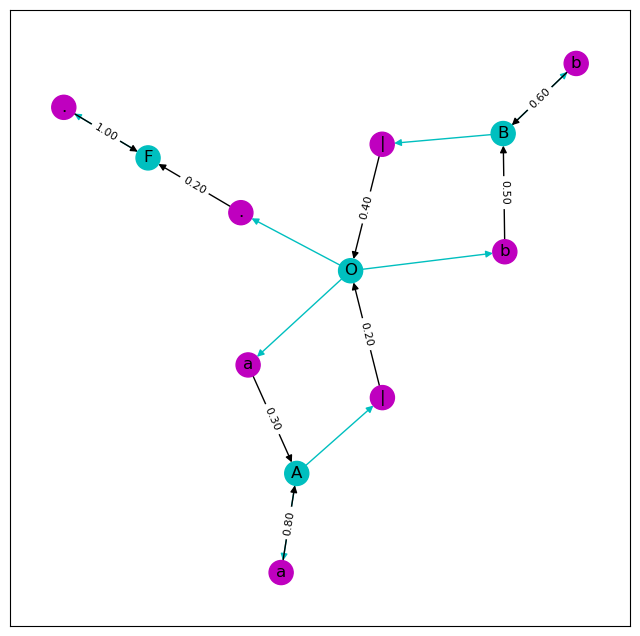

In [2]:
X = PFSA.from_str('''
F->F . 1.
O->A a .3
O->B b .5
O->F . .2
A->A a .8
A->O | .2
B->B b .6
B->O | .4
''')
X.draw(ax=dict(figsize=(8,8)))
X

Draw a large sample from state 'O'

In [3]:
sample = test(X,100000,start='O')

Deterministic: True
Producing sample of size 100000 on 13 batches [0.416s]
Expected length
	empirical  : 17.72193 [0.00585s]
	theoretical: 17.75 [7.56e-05s]
Entropy
	empirical  : 13.0974043227935 [0.63s]
	theoretical: 13.1076061656671 [0.000282s]
Sample (10/100000)
10463    56   aaaaaaaaaaaaaa|bbbb|aa|aaaaaaaa|aaa|aaaaaaaaaaaa|a|b|bb|
79464     4   bbb|
11424    40   b|bbbbbbb|a|b|aa|b|aaaa|aaaaaaa|bbb|aaa|
 4045    68   bbbbbbbbb|bbbb|b|aaaaa|aaaaa|aaaaaaaaaaaaaaa|bb|aaaaa|bbbb|bb|aaaaa|
54982     0   
47069     0   
86721    12   aaa|aa|bbbb|
73795     0   
67122     3   bb|
57464     6   aa|bb|


## Another example with super easy entropy

Closed form of entropy: $\frac{-p\log p-q\log q}{q}$

INFO:wfsa.probabilistic:Inferred stop symbol and final state: . F


🛈,F,O
F,1.0,
O,0.3,0.7


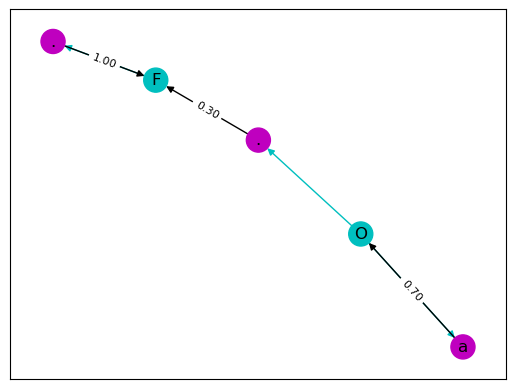

In [4]:
p = .7; q = 1.-p
X = PFSA.from_str(f'''
F->F . 1.
O->O a {p}
O->F . {q}
''')
X.draw(k=2,K=1)
X

In [5]:
sample = test(X,100000,start='O',avglen=p/q,entropy=-(p*log(p)+q*log(q))/q)

Deterministic: True
Producing sample of size 100000 on 10 batches [0.0663s]
Expected length
	empirical  : 2.31894 [0.0011s]
	theoretical: 2.33333333333333 [8.46e-05s]
	alternative: 2.33333333333333
Entropy
	empirical  : 2.03108059882322 [0.0685s]
	theoretical: 2.03621434018298 [0.000258s]
	alternative: 2.03621434018298
Sample (10/100000)
11266    6   aaaaaa
61704    1   a
80328    0   
26361    3   aaa
15210    3   aaa
22839    3   aaa
81593    0   
81684    0   
22772    4   aaaa
94241    2   aa


## Other example with sparse matrices

Closed form of entropy: $L(-p\log p-q\log q)$

In [6]:
p =.7; L = 100; q = 1.-p
W = [*(z*eye(L+1,k=1) for z in (p,q)),zeros((L+1,L+1))]
W[-1][-1,-1] = 1
W = [csra_matrix.initial(w) for w in W]
X = PFSA(W,symb_names=('a','b','.'))
X

INFO:wfsa.probabilistic:Inferred stop symbol and final state: . 100


🛈


In [7]:
sample = test(X,10000,start=0,avglen=L,entropy=-L*(p*log(p)+q*log(q)))

Deterministic: True
Producing sample of size 10000 on 1 batches [0.0889s]
Expected length
	empirical  : 100 [0.00241s]
	theoretical: 100 [3.98e-05s]
	alternative: 100
Entropy
	empirical  : 61.0847356097686 [9.15s]
	theoretical: 61.0864302054893 [0.00145s]
	alternative: 61.0864302054893
Sample (10/10000)
7243   100   baaabbaaaababaabbaabaaaaaaaabbaaaaaaaaaababaabaaababaababbaaaabaaaabbaaaaaaabaaaaababaabbabaaaababba
8552   100   aaabaaaaaaaaabaabaabbbaaabbabbaabaaaaaabaabbbbaaaaaaaaaababbaaabaaaaabaabbbbbaaaaaaaaabbabaabaaabaaa
8608   100   aaaababbabaaaaaaaaaaaaaaabaaaabaaaababaaababaaaaabaaaaabaaaaaabaabaaaaaababaaabbaaaaaaaaaaabaaaababa
5573   100   aaaaabbaaaaaabbaaaabababaaaaababaababaaaaaaaaaaaaaaaaaabaaabaabaaaaabbaabaabbaaaabbabaaaababaaaaaaaa
4340   100   abbabbabaaaaaaaababbaaababbabaaaaabaabbaabababaaaabbaaaaaabaaabbaabaaaaababbabaaaaababaaaaaaaabababa
3254   100   baaaaaaaabaaaaaaabaaaaabbbaaabbaaaaaabaaaaaaabaaabaaaaaaaabaaaaaabaaabbaababbaababaababaababababbbaa
8373   100 

## Pruning

In [8]:
X = WFSA.from_str('''
F->F . 1.
O->A a .3
O->B b .5
O->F . .2
A->A a .8
A->O | .2
B->B b .6
B->O | .4
U->V | 1
U->V a 1
U->V b 1
V->U | 1
V->U a 1
V->U b 1
U->W | 1
U->W a 1
U->W b 1
V->W | 1
V->W a 1
V->W b 1
W->W | 0
''')
X

🛈,F,O,A,B,U,V,W
F,1.0,,,,,,
O,0.2,,0.3,0.5,,,
A,,0.2,0.8,,,,
B,,0.4,,0.6,,,
U,,,,,,3.0,3.0
V,,,,,3.0,,3.0
W,,,,,,,


INFO:wfsa.probabilistic:Inferred stop symbol and final state: . F
INFO:wfsa.probabilistic:Pruning unreachable states: 3/7


🛈,F,O,A,B
F,1.0,,,
O,0.2,,0.3,0.5
A,,0.2,0.8,
B,,0.4,,0.6


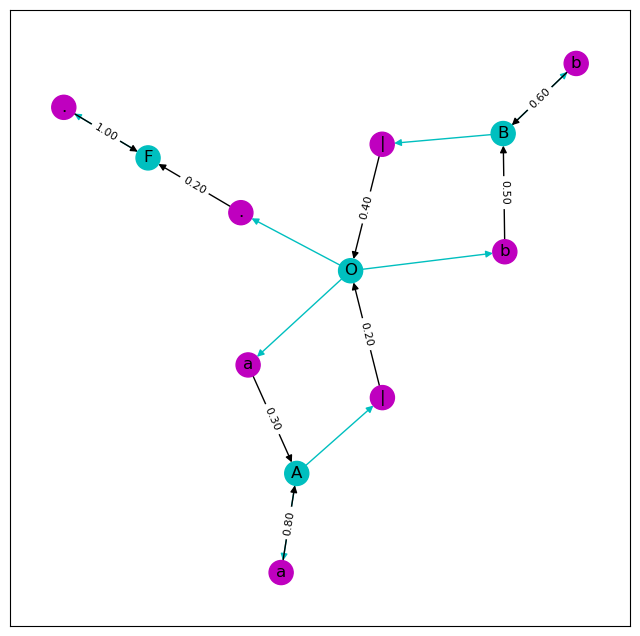

In [9]:
X = PFSA.fromWFSA(X)
X.draw(ax=dict(figsize=(8,8)))
X

## Intersection

In [13]:
L = 5
template,wstop = eye(L+1,k=1),zeros((L+1,L+1)); wstop[-1,-1] = 1.
template,wstop = map(csra_matrix.initial,(template,wstop))
X_len = WFSA([wstop],template=template,symb_names=('.',),state_names=[f'L{k}' for k in range(L,-1,-1)])

X_cnt = WFSA.from_str('''
O->O a .7
O->O b .5
O->O . 1
''',sparse=True)

X_mot = WFSA.from_str('''
F->F a 1
F->F b 1
F->F . 1
O->A a 1
O->O b 1
A->F b 1
A->A a 1
''',sparse=True)
X = X_len@X_mot@X_cnt
# there is probably a bug as changing the order of the factors yields proba>1 in the PFSA
X

🛈,L5.F.O,L5.O.O,L5.A.O,L4.F.O,L4.O.O,L4.A.O,L3.F.O,L3.O.O,L3.A.O,L2.F.O,L2.O.O,L2.A.O,L1.F.O,L1.O.O,L1.A.O,L0.F.O,L0.O.O,L0.A.O
L5.F.O,,,,1.2,,,,,,,,,,,,,,
L5.O.O,,,,,0.5,0.7,,,,,,,,,,,,
L5.A.O,,,,0.5,,0.7,,,,,,,,,,,,
L4.F.O,,,,,,,1.2,,,,,,,,,,,
L4.O.O,,,,,,,,0.5,0.7,,,,,,,,,
L4.A.O,,,,,,,0.5,,0.7,,,,,,,,,
L3.F.O,,,,,,,,,,1.2,,,,,,,,
L3.O.O,,,,,,,,,,,0.5,0.7,,,,,,
L3.A.O,,,,,,,,,,0.5,,0.7,,,,,,
L2.F.O,,,,,,,,,,,,,1.2,,,,,


INFO:wfsa.probabilistic:Inferred stop symbol and final state: . L0.F.O
INFO:wfsa.probabilistic:Pruning unreachable states: 3/18
INFO:wfsa.probabilistic:Normaliser min: 0.35 max: 2.48832


🛈,L5.F.O,L5.O.O,L5.A.O,L4.F.O,L4.O.O,L4.A.O,L3.F.O,L3.O.O,L3.A.O,L2.F.O,L2.O.O,L2.A.O,L1.F.O,L1.A.O,L0.F.O
L5.F.O,,,,1.0,,,,,,,,,,,
L5.O.O,,,,,0.35,0.65,,,,,,,,,
L5.A.O,,,,0.45,,0.55,,,,,,,,,
L4.F.O,,,,,,,1.0,,,,,,,,
L4.O.O,,,,,,,,0.3,0.7,,,,,,
L4.A.O,,,,,,,0.47,,0.53,,,,,,
L3.F.O,,,,,,,,,,1.0,,,,,
L3.O.O,,,,,,,,,,,0.21,0.79,,,
L3.A.O,,,,,,,,,,0.52,,0.48,,,
L2.F.O,,,,,,,,,,,,,1.0,,


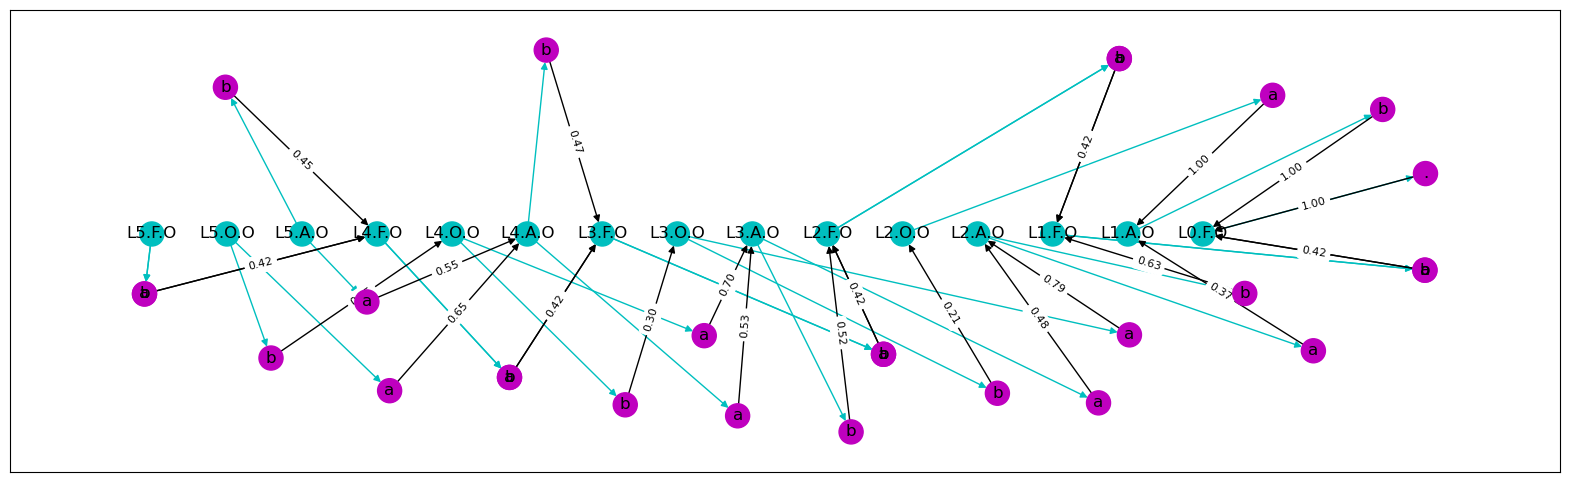

In [14]:
X = PFSA.fromWFSA(X)
X.draw(ax=dict(figsize=(20,6)),k=6.,weight=None) # some edges (pink nodes) overlap
X

In [15]:
def allstr(X,L):
  R = [c for c in range(len(X.W)) if c!=X.stop]
  m = X.n-1
  sample = empty((L+1,Q),dtype=int)
  sample[L] = X.stop
  for k in range(L): sample[k] = tile(repeat(R,m**(L-1-k)),m**k)
  return sample
Q = (X.n-1)**L
sample = Sample(Q)
sample.append(allstr(X,L))
X.asample = sample.close()

P = exp(X.logproba(sample,start=f'L{L}.O.O'))
for x,p in zip(sample.values(),P): print(''.join(X.symb_names[c] for c in x),p)
print('Total probability:',sum(P))
print('Entropy:',X.entropy(start=f'L{L}.O.O'))

aaaaa. 0.0
aaaab. 0.06068648266100495
aaaba. 0.06068648266100495
aaabb. 0.04334748761500354
aabaa. 0.06068648266100498
aabab. 0.04334748761500356
aabba. 0.04334748761500356
aabbb. 0.030962491153573968
abaaa. 0.06068648266100498
abaab. 0.04334748761500356
ababa. 0.04334748761500356
ababb. 0.030962491153573968
abbaa. 0.04334748761500354
abbab. 0.030962491153573954
abbba. 0.030962491153573954
abbbb. 0.02211606510969568
baaaa. 0.0
baaab. 0.04334748761500352
baaba. 0.04334748761500352
baabb. 0.03096249115357394
babaa. 0.04334748761500354
babab. 0.030962491153573954
babba. 0.030962491153573954
babbb. 0.02211606510969568
bbaaa. 0.0
bbaab. 0.030962491153573954
bbaba. 0.030962491153573954
bbabb. 0.02211606510969568
bbbaa. 0.0
bbbab. 0.02211606510969568
bbbba. 0.0
bbbbb. 0.0
Total probability: 1.0000000000000002
Entropy: 3.2101229700352256


## Entropy not computable

INFO:wfsa.probabilistic:Inferred stop symbol and final state: . F


🛈,F,O,B,A3,A2,A1,A0
F,1.0,,,,,,
O,0.15,,0.25,0.3,0.2,0.1,
B,,0.2,0.8,,,,
A3,,,,,1.0,,
A2,,,,,,1.0,
A1,,,,,,,1.0
A0,,1.0,,,,,


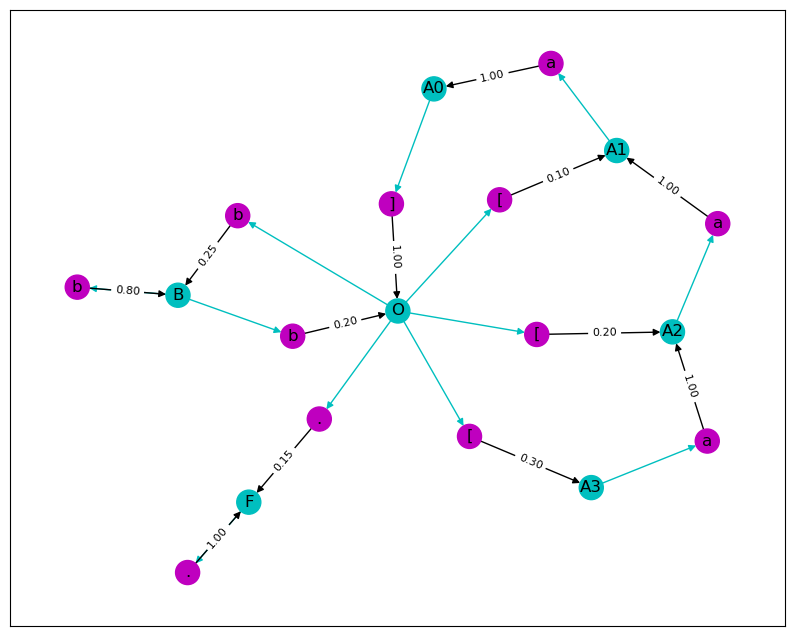

In [16]:
X = PFSA.from_str('''
F->F . 1.
O->A3 [ .3
O->A2 [ .2
O->A1 [ .1
O->B b .25
O->F . .15
B->B b .8
B->O b .2
A3->A2 a 1.
A2->A1 a 1.
A1->A0 a 1.
A0->O ] 1.
''')
X.draw(ax=dict(figsize=(10,8)),layout='kamada_kawai')
X

In [17]:
sample = test(X,10000,start='O')

Deterministic: False
Producing sample of size 10000 on 10 batches [0.257s]
Expected length
	empirical  : 27.1377 [0.00106s]
	theoretical: 27.3333333333333 [6.87e-05s]
Entropy
	empirical  : 12.8965140735367 [0.16s]
	theoretical: Error! [2.48e-05s]
Sample (10/10000)
8907     8   bbbbb[a]
8242     0   
5256    20   [aaa][aa]bbbbbbbbbbb
5104    23   bbbbbbbbbbbb[a]bbbbbbbb
8104    26   [a]bbbbb[aa][aa][aaa][aaa]
4814    12   bbbbbbb[aaa]
4731    10   [aa]bbbbbb
4385     0   
1666    44   bbbb[a][aaa]bbbbbbbbbbbbbbbbbbb[a][aa][a][a]
3824    19   [aa][aaa]bbbbb[aaa]


NotImplementedError: Entropy available only for deterministic automata

# Sample management

In [15]:
R = FileBatch('samples')
sample = R.toSample()
sample

In [16]:
sample.pprint('[b.a]',pick=10,translate={ord('.'):''})

9254    19   [aaa][aaa][aaa][aa]
 947    85   [aa][aa]bbbbbbbbbbbbbb[aa][aa][aaa][a][aa]bbbbbbbb[aaa]bb[aa][aaa][aaa][a][a][aaa]bbb
2452    32   [aa][aaa]bbbbbbbbb[aaa][aaa][aa]
4872     5   [aaa]
8900    27   [a][a]bbbbbb[aaa][aaa][aaa]
5941     0   
4528    10   [a][aa][a]
8909     7   [aaa]bb
6740     0   
8842    13   [aa][aa][aaa]
